In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Chargez le fichier CSV dans un DataFrame pandas
df = pd.read_csv("dataTp2.csv")

# Renommez la colonne 'Unnamed: 0' en 'internaute_id'
df.rename(columns={'Unnamed: 0': 'internaute_id'}, inplace=True)

# Affichez les premières lignes du DataFrame
df.head()

,internaute_id,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,2157,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,1223,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,1083,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,456,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,1448,0.458818,0.483091,0.406909,0.297818,0.395273,0


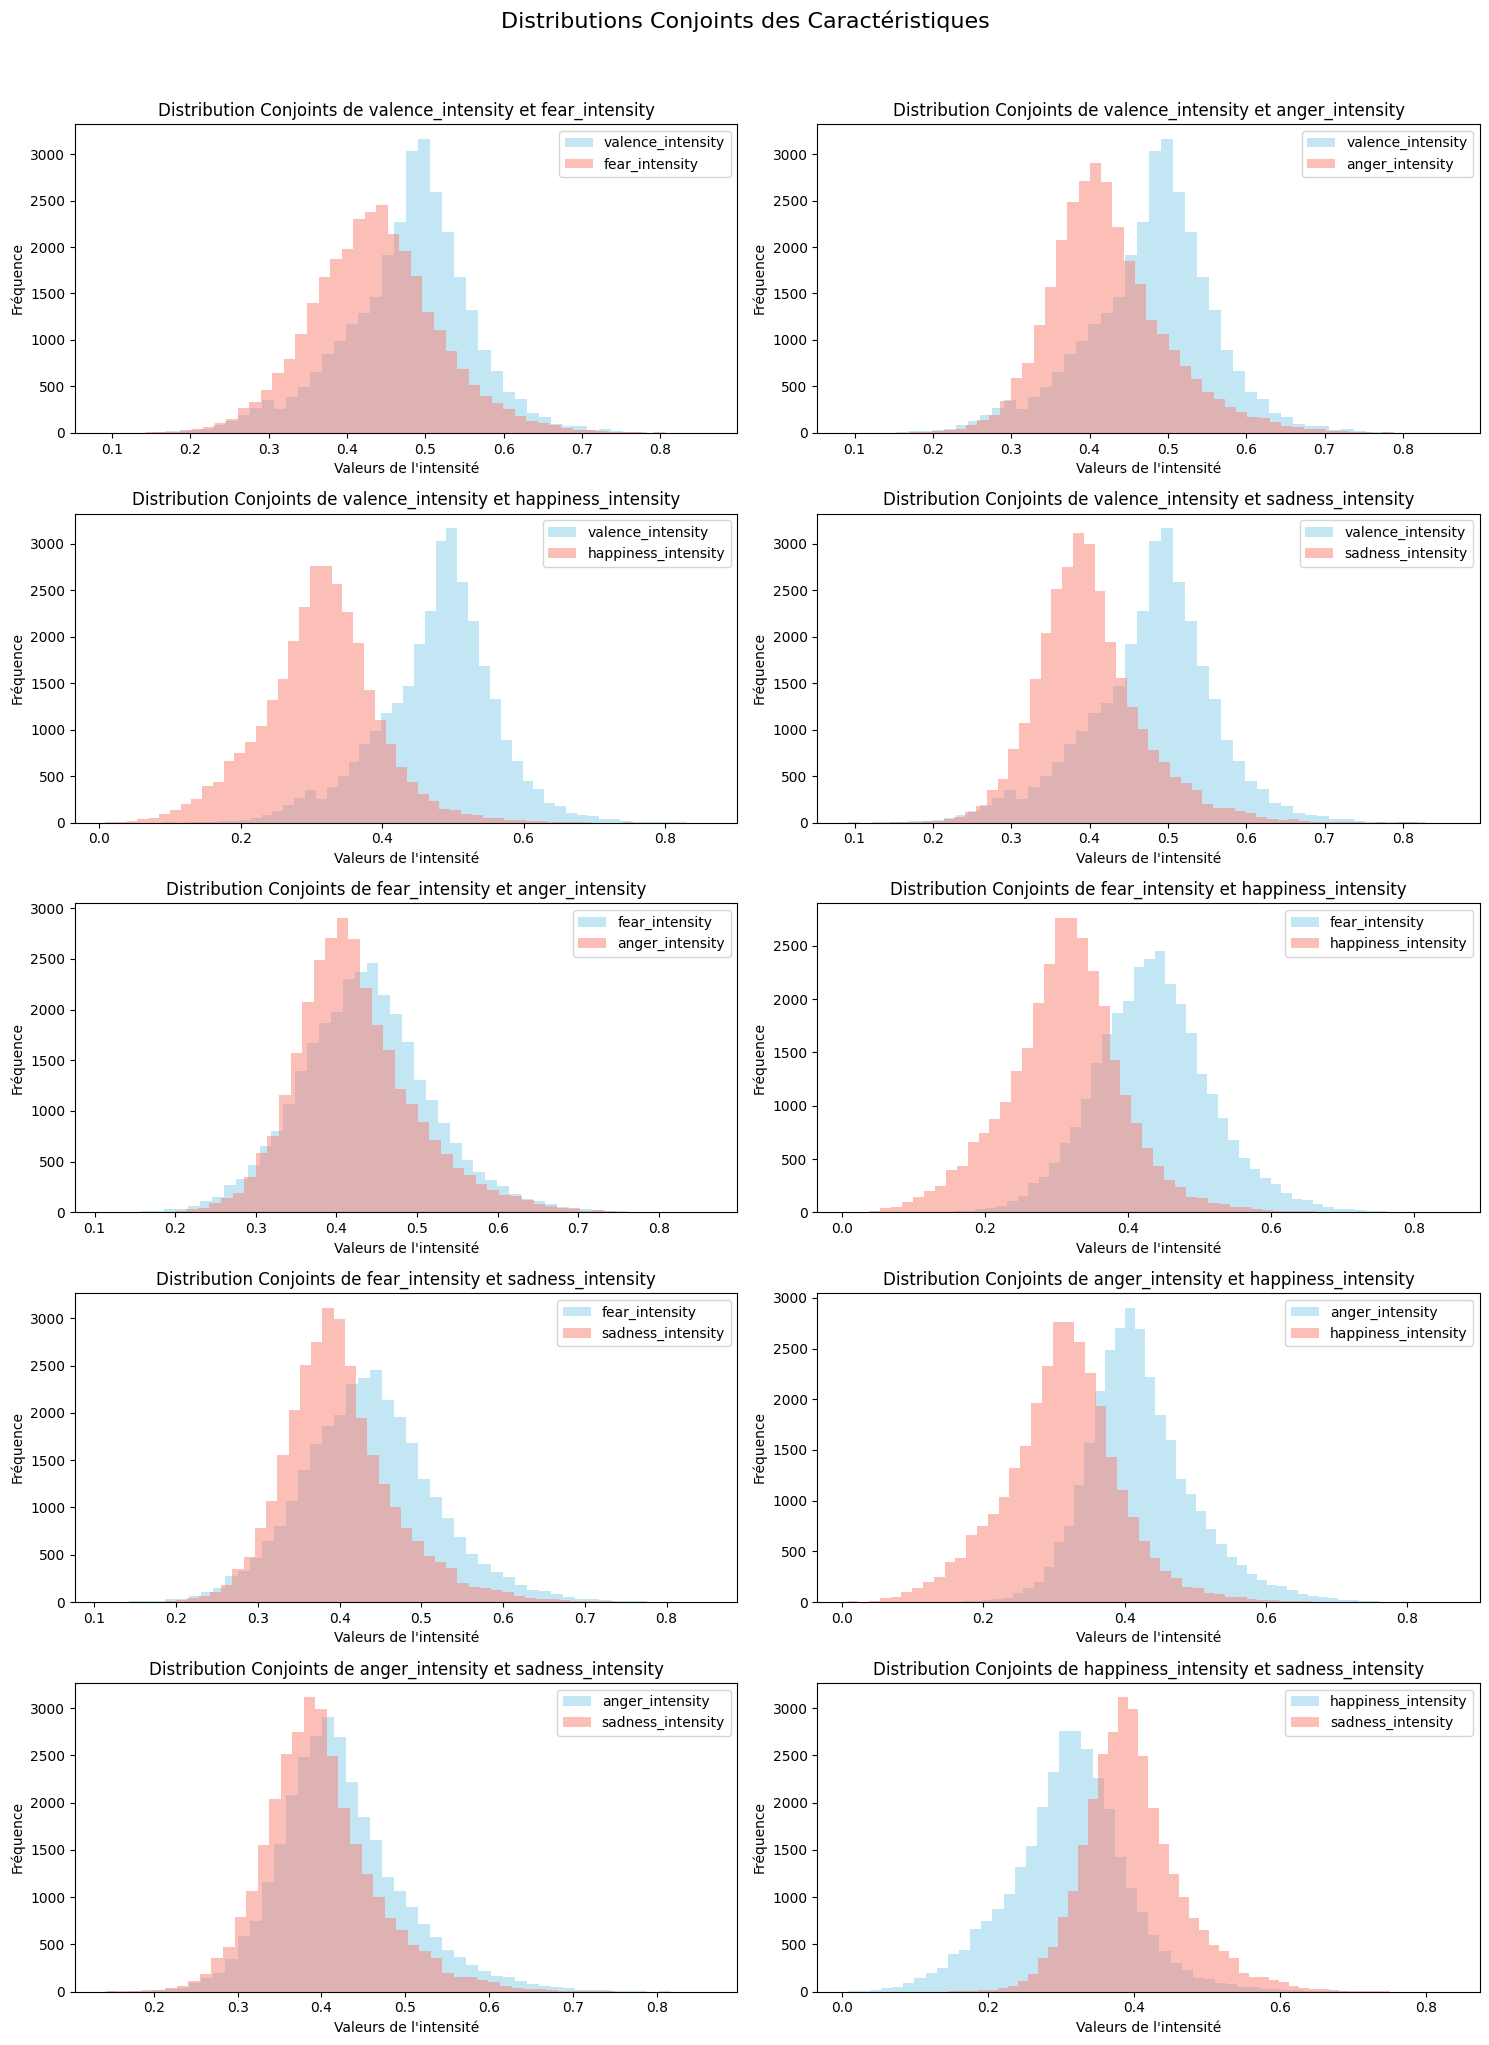

In [31]:
# Sélectionnez les caractéristiques pour les graphiques de distribution conjointe
caracteristiques_selectionnees = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']

# Créez toutes les paires possibles de caractéristiques
paires_de_caracteristiques = [(caracteristique1, caracteristique2) for i, caracteristique1 in enumerate(caracteristiques_selectionnees) for caracteristique2 in caracteristiques_selectionnees[i+1:]]

# Créez les histogrammes de distribution conjointe
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Distributions Conjoints des Caractéristiques', y=1.02, fontsize=16)

for i, (caracteristique1, caracteristique2) in enumerate(paires_de_caracteristiques):
    ligne, col = divmod(i, 2)
    
    # Tracé des histogrammes avec des couleurs différentes pour chaque caractéristique
    axes[ligne, col].hist(df[caracteristique1], bins=50, color='skyblue', alpha=0.5, label=caracteristique1)
    axes[ligne, col].hist(df[caracteristique2], bins=50, color='salmon', alpha=0.5, label=caracteristique2)
    
    axes[ligne, col].set_title(f'Distribution Conjoints de {caracteristique1} et {caracteristique2}')
    axes[ligne, col].set_xlabel('Valeurs de l\'intensité')
    axes[ligne, col].set_ylabel('Fréquence')
    axes[ligne, col].legend()

plt.tight_layout()
plt.show()

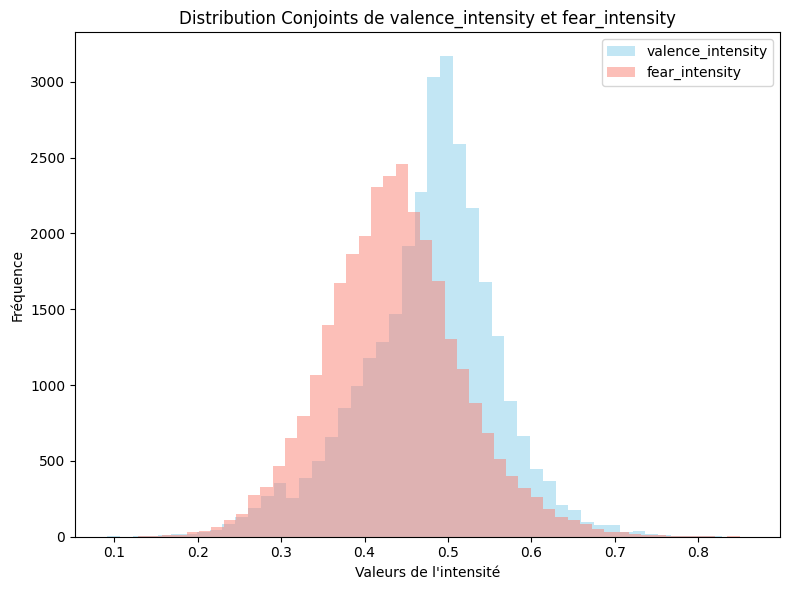

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que df est votre DataFrame après avoir chargé vos données.

# Sélectionnez les caractéristiques pour le graphique de distribution conjointe
caracteristiques_selectionnees = ['valence_intensity', 'fear_intensity']

# Assurez-vous qu'il y a deux caractéristiques à comparer
if len(caracteristiques_selectionnees) == 2:
    caracteristique1, caracteristique2 = caracteristiques_selectionnees

    # Créez le histogramme de distribution conjointe
    plt.figure(figsize=(8, 6))
    plt.hist(df[caracteristique1], bins=50, color='skyblue', alpha=0.5, label=caracteristique1)
    plt.hist(df[caracteristique2], bins=50, color='salmon', alpha=0.5, label=caracteristique2)
    
    plt.title(f'Distribution Conjoints de {caracteristique1} et {caracteristique2}')
    plt.xlabel('Valeurs de l\'intensité')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Veuillez sélectionner exactement deux caractéristiques.")


/home/okhaloui/Documents/UDS/Sciences de données/TP2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


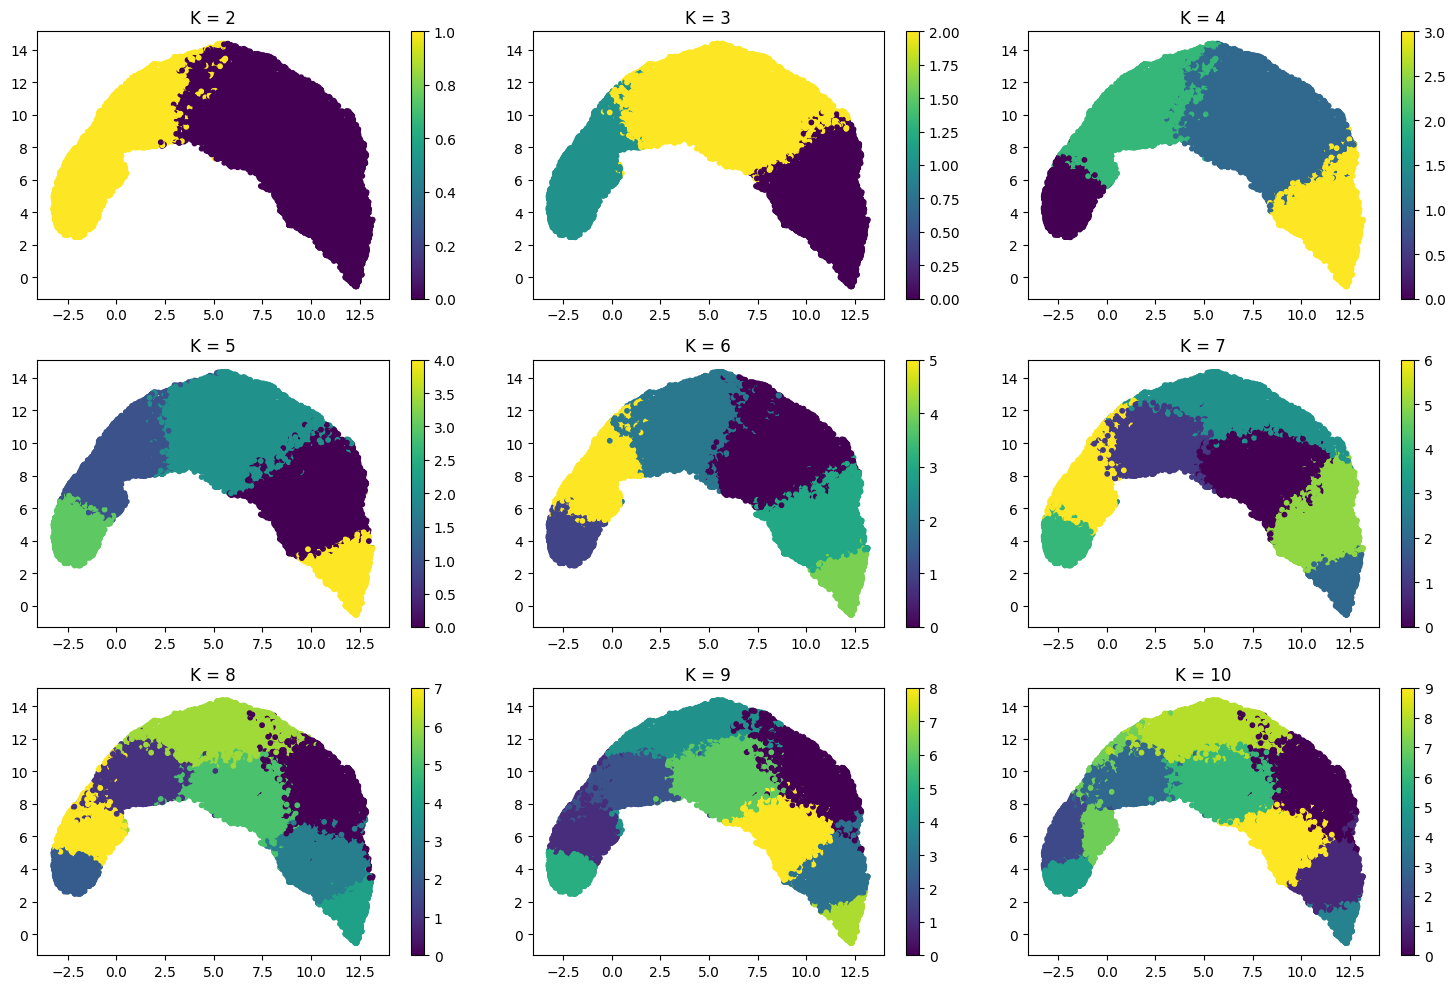

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 
# Assuming df is your DataFrame
# Sélectionner les caractéristiques pour l'analyse K-means
features = df[['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']]
 
# Appliquer K-means pour différentes valeurs de K
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster_k{}'.format(k)] = kmeans.fit_predict(features)
 
# Import UMAP from umap-learn
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
 
# Visualiser les clusters pour chaque valeur de K avec UMAP
plt.figure(figsize=(15, 10))
 
for i, k in enumerate(k_values, 1):
    plt.subplot(3, 3, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=df['cluster_k{}'.format(k)], cmap='viridis', s=10)
    plt.title('K = {}'.format(k))
    plt.colorbar()
 
plt.tight_layout()
plt.show()